<a href="https://colab.research.google.com/github/GitBar20/AI/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Test1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Работа с операционной системой
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

    # Возврат готовой модели
    return model

In [4]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5):

    plt.figure(figsize=(28, 14))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [5]:
base_dir = "/content/drive/MyDrive/Build /Dset_build"

In [6]:
shap1 = 256

In [7]:
patch = 0

x_train = []
y_train = []
img_height = shap1
img_wight = shap1
for patch in os.listdir(base_dir):
  for img in os.listdir(base_dir + "/" + patch):
      x_train.append(image.img_to_array(image.load_img(base_dir + "/" + patch +"/"+ img,
                                                       target_size=(img_height,img_wight),
                                                       color_mode="grayscale")))
      y_train.append(0)

In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print("размер x", x_train.shape)
print("размер y", y_train.shape)


размер x (31, 256, 256, 1)
размер y (31,)


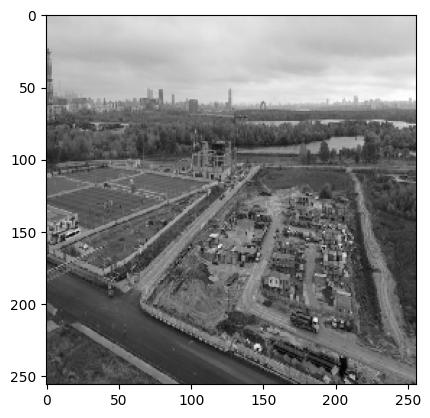

0


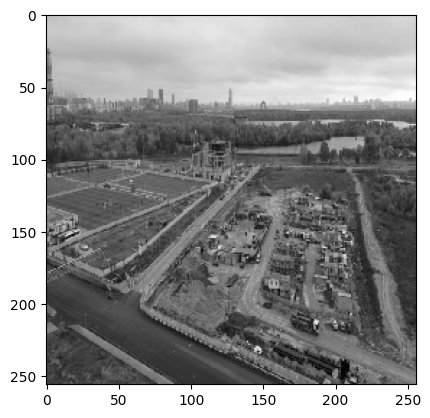

0


In [9]:
N_example = 1

plt.imshow(np.reshape(x_train[N_example],(shap1, shap1)), cmap = "gray")
plt.show()
print(y_train[N_example])
N_example = 5
plt.imshow(np.reshape(x_train[N_example],(shap1, shap1)), cmap = "gray")
plt.show()
print(y_train[N_example])

In [10]:
x_shuffle = x_train.copy()
np.random.shuffle(x_shuffle)


In [ ]:
# shap2 = shap1 * shap1
# x_train = x_train.reshape(x_train.shape[0],shap2)


In [11]:
print(x_train.shape)

(31, 256, 256, 1)


In [12]:
x_train = x_train.astype("float32")
x_train = x_train / 255
print(y_train.shape)
y_train = utils.to_categorical(y_train,0)
print(y_train.shape)



(31,)
(31, 1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (24, 256, 256, 1)
Размер тестовой выборки: (7, 256, 256, 1)


In [14]:
# Проверка формы данных
print(X_train.shape)
print(X_test.shape)

(24, 256, 256, 1)
(7, 256, 256, 1)


In [ ]:
# X_train = X_train.reshape(-1, shap1, shap1, 1)
# print(X_train.shape)

In [15]:
print(X_train.shape[1:])

(256, 256, 1)


In [23]:
# Сборка автокодировщика для формы картинок датасета
ae_week = create_base_ae(X_train.shape[1:])

In [24]:
# Сводка архитектуры автокодировщика
ae_week.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_11 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0   

In [25]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_week.fit(X_train, X_train,
                       epochs=90,
                       batch_size=1,
                       validation_data = (X_test, X_test)
                       )

Epoch 1/90
24/24 [==============================] - 6s 40ms/step - loss: 0.0550 - val_loss: 0.0507
Epoch 2/90
24/24 [==============================] - 0s 21ms/step - loss: 0.0247 - val_loss: 0.0501
Epoch 3/90
24/24 [==============================] - 0s 19ms/step - loss: 0.0146 - val_loss: 0.0501
Epoch 4/90
24/24 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0504
Epoch 5/90
24/24 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0504
Epoch 6/90
24/24 [==============================] - 0s 21ms/step - loss: 0.0071 - val_loss: 0.0504
Epoch 7/90
24/24 [==============================] - 0s 21ms/step - loss: 0.0064 - val_loss: 0.0501
Epoch 8/90
24/24 [==============================] - 0s 20ms/step - loss: 0.0059 - val_loss: 0.0492
Epoch 9/90
24/24 [==============================] - 0s 20ms/step - loss: 0.0055 - val_loss: 0.0480
Epoch 10/90
24/24 [==============================] - 0s 19ms/step - loss: 0.0053 - val_loss: 0.0465
Epoch 11/

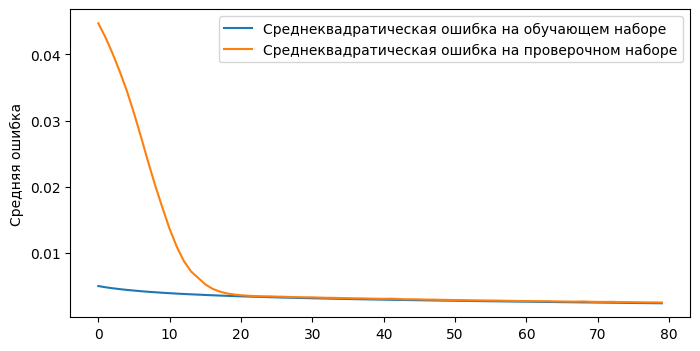

In [26]:
# Вывод графиков процесса обучения
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'][10:],
         label='Среднеквадратическая ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:],
         label='Среднеквадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
# путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [28]:
# Сохранение/восстановление параметров модели
ae_week.save_weights(PATH + '/ae_week.h5') # Сохраняем модель
ae_week.load_weights(PATH + '/ae_week.h5') # Загружаем модель

In [29]:
# Получение предсказания автокодировщика на тренировочной и тестовой выборках
pred_train = ae_week.predict(X_train)
pred_test = ae_week.predict(X_test)

1/1 [==============================] - 1s 544ms/step


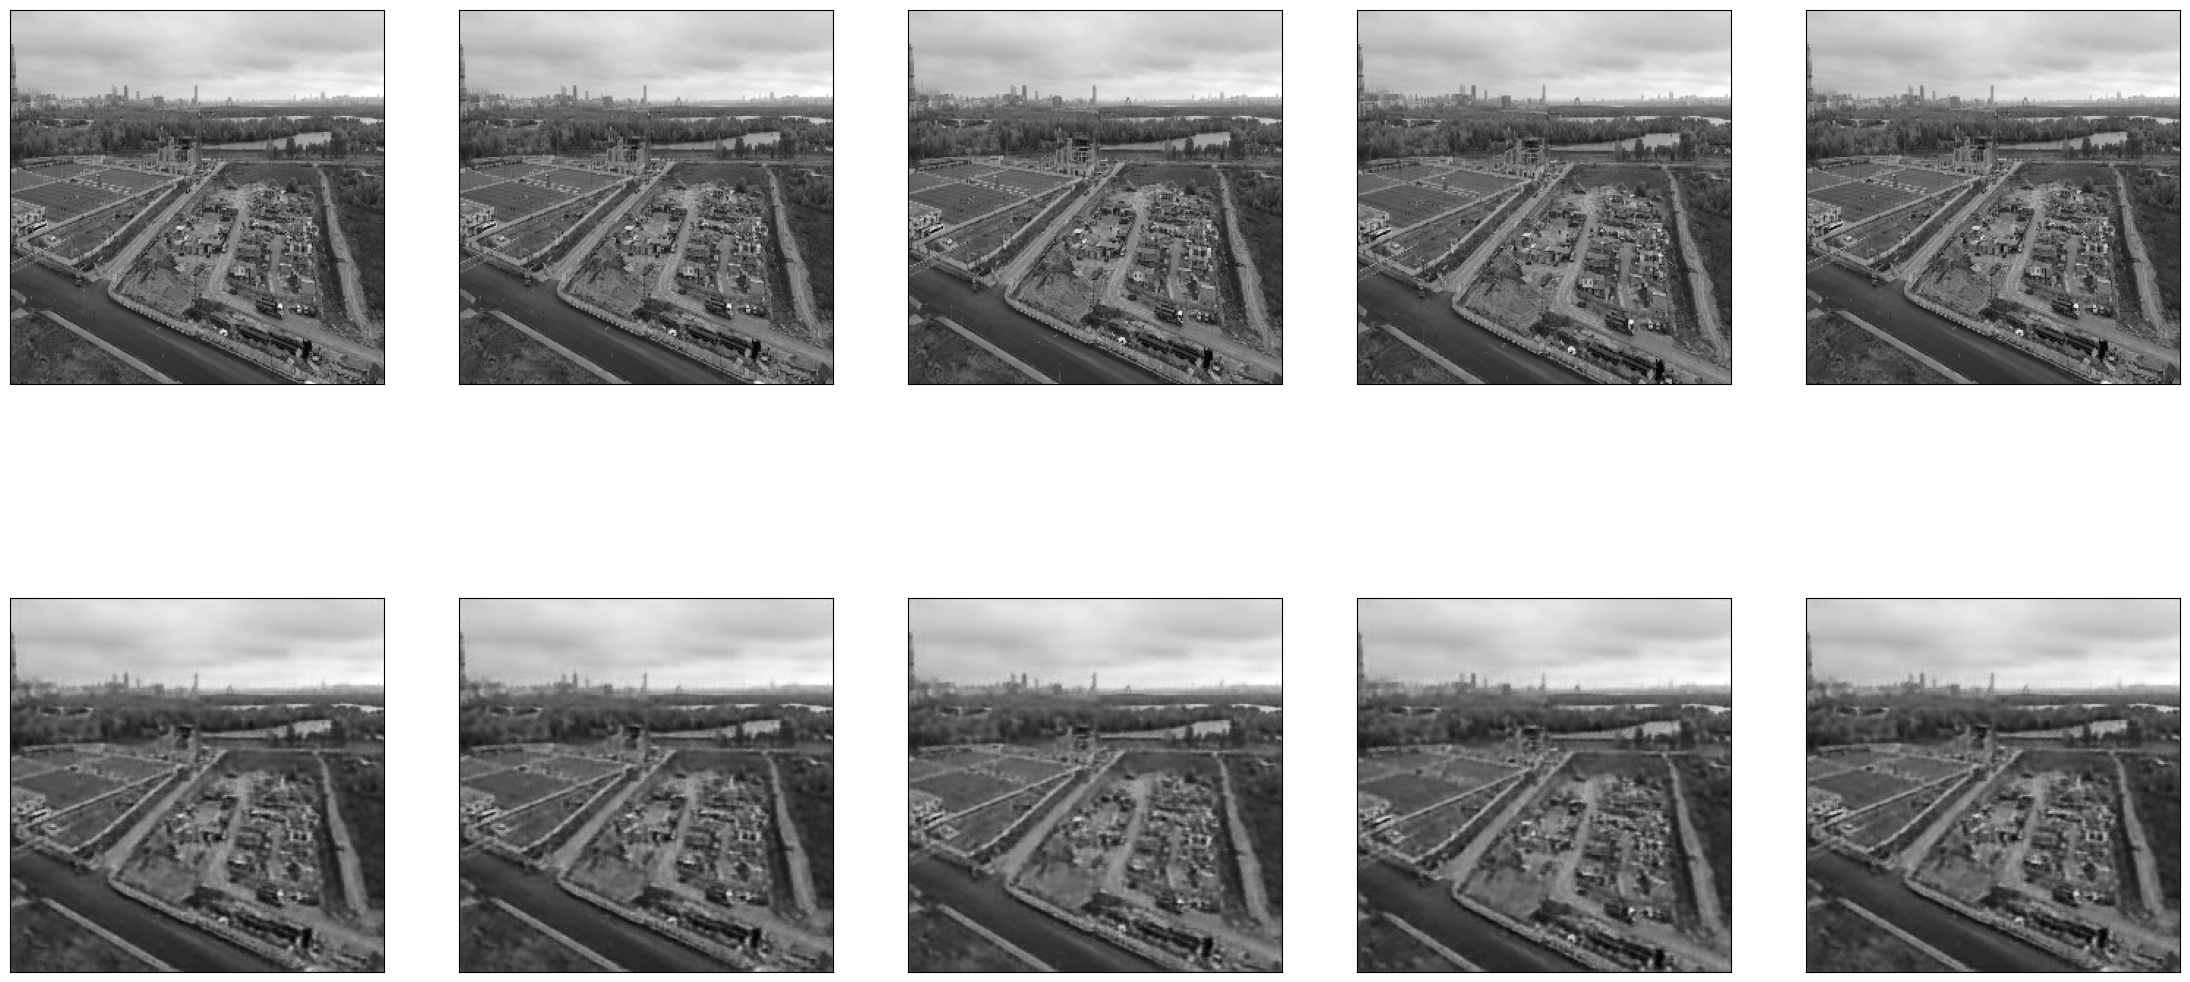

In [30]:
# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(X_test, pred_test)

In [31]:
# Расчет количества пикселей изображения
image_size = X_train.shape[1] * X_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train = mean_squared_error(X_train.reshape(-1, image_size).T,
                                     pred_train.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе Week: {err_train.mean()}')
print(f'Средняя ошибка на  тестовом наборе Week: {err_test.mean()}')

Средняя ошибка на обучающем наборе Week: 0.002450215630233288
Средняя ошибка на  тестовом наборе Week: 0.002559877699241042
